##### Ref: This Notebook comes from [LibreCV](https://librecv.github.io/blog/gans/pytorch/2021/02/13/Pix2Pix-explained-with-code.html)

<!--<badge>--><a href="https://colab.research.google.com/github/gradsflow/gradsflow/blob/main/examples/nbs/Pix2Pix_explained_with_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

**Pix2Pix** is an image-to-image translation Generative Adversarial Networks that learns a mapping from an image X and a random noise Z to output image Y or in simple language it learns to translate the source image into a different distribution of image.
![Pix2Pix Generator arch](https://ik.imagekit.io/aniket/blog/pix2pix/pix2pix_Unet_arch_Oen99KmZw)

In [ ]:
# hide
import os

# os.chdir("../../")

In [ ]:
# collapse-hide
import os
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.transforms.functional import center_crop
from torchvision.utils import make_grid
from tqdm.auto import tqdm

Uncomment the below code to download the dataset

In [ ]:
# !wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
# !tar -xvf facades.tar.gz

After downloading the dataset we create Dataloader which loads our conditional and real image.

In [ ]:
path = "./facades/train/"


class FacadesDataset(Dataset):
    def __init__(self, path, target_size=None):
        self.filenames = glob(str(Path(path) / "*"))
        self.target_size = target_size

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        image = Image.open(filename)
        image = transforms.functional.to_tensor(image)
        image_width = image.shape[2]

        real = image[:, :, : image_width // 2]
        condition = image[:, :, image_width // 2 :]

        target_size = self.target_size
        if target_size:
            condition = nn.functional.interpolate(condition, size=target_size)
            real = nn.functional.interpolate(real, size=target_size)

        return real, condition

In the first part of U-Net shaped network the layer size decreases, we create a `DownSampleConv` module for this. This module will contain the unit block that we just created `ConvBlock`.

In [ ]:
class DownSampleConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel=4, strides=2, padding=1, activation=True, batchnorm=True):
        """
        Paper details:
        - C64-C128-C256-C512-C512-C512-C512-C512
        - All convolutions are 4×4 spatial filters applied with stride 2
        - Convolutions in the encoder downsample by a factor of 2
        """
        super().__init__()
        self.activation = activation
        self.batchnorm = batchnorm

        self.conv = nn.Conv2d(in_channels, out_channels, kernel, strides, padding)

        if batchnorm:
            self.bn = nn.BatchNorm2d(out_channels)

        if activation:
            self.act = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.conv(x)
        if self.batchnorm:
            x = self.bn(x)
        if self.activation:
            x = self.act(x)
        return x

Now in the second part the network expands and so we create `UpSampleConv`

In [ ]:
class UpSampleConv(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel=4, strides=2, padding=1, activation=True, batchnorm=True, dropout=False
    ):
        super().__init__()
        self.activation = activation
        self.batchnorm = batchnorm
        self.dropout = dropout

        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel, strides, padding)

        if batchnorm:
            self.bn = nn.BatchNorm2d(out_channels)

        if activation:
            self.act = nn.ReLU(True)

        if dropout:
            self.drop = nn.Dropout2d(0.5)

    def forward(self, x):
        x = self.deconv(x)
        if self.batchnorm:
            x = self.bn(x)

        if self.dropout:
            x = self.drop(x)
        return x

In [ ]:
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Paper details:
        - Encoder: C64-C128-C256-C512-C512-C512-C512-C512
        - All convolutions are 4×4 spatial filters applied with stride 2
        - Convolutions in the encoder downsample by a factor of 2
        - Decoder: CD512-CD1024-CD1024-C1024-C1024-C512 -C256-C128
        """
        super().__init__()

        # encoder/donwsample convs
        self.encoders = [
            DownSampleConv(in_channels, 64, batchnorm=False),  # bs x 64 x 128 x 128
            DownSampleConv(64, 128),  # bs x 128 x 64 x 64
            DownSampleConv(128, 256),  # bs x 256 x 32 x 32
            DownSampleConv(256, 512),  # bs x 512 x 16 x 16
            DownSampleConv(512, 512),  # bs x 512 x 8 x 8
            DownSampleConv(512, 512),  # bs x 512 x 4 x 4
            DownSampleConv(512, 512),  # bs x 512 x 2 x 2
            DownSampleConv(512, 512, batchnorm=False),  # bs x 512 x 1 x 1
        ]

        # decoder/upsample convs
        self.decoders = [
            UpSampleConv(512, 512, dropout=True),  # bs x 512 x 2 x 2
            UpSampleConv(1024, 512, dropout=True),  # bs x 512 x 4 x 4
            UpSampleConv(1024, 512, dropout=True),  # bs x 512 x 8 x 8
            UpSampleConv(1024, 512),  # bs x 512 x 16 x 16
            UpSampleConv(1024, 256),  # bs x 256 x 32 x 32
            UpSampleConv(512, 128),  # bs x 128 x 64 x 64
            UpSampleConv(256, 64),  # bs x 64 x 128 x 128
        ]
        self.decoder_channels = [512, 512, 512, 512, 256, 128, 64]
        self.final_conv = nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1)
        self.tanh = nn.Tanh()

        self.encoders = nn.ModuleList(self.encoders)
        self.decoders = nn.ModuleList(self.decoders)

    def forward(self, x):
        skips_cons = []
        for encoder in self.encoders:
            x = encoder(x)

            skips_cons.append(x)

        skips_cons = list(reversed(skips_cons[:-1]))
        decoders = self.decoders[:-1]

        for decoder, skip in zip(decoders, skips_cons):
            x = decoder(x)
            # print(x.shape, skip.shape)
            x = torch.cat((x, skip), axis=1)

        x = self.decoders[-1](x)
        # print(x.shape)
        x = self.final_conv(x)
        return self.tanh(x)

Now we create our Discriminator - **PatchGAN**. In this network we use the same `DownSampleConv` module that we created for generator.

In [ ]:
class PatchGAN(nn.Module):
    def __init__(self, input_channels):
        super().__init__()
        self.d1 = DownSampleConv(input_channels, 64, batchnorm=False)
        self.d2 = DownSampleConv(64, 128)
        self.d3 = DownSampleConv(128, 256)
        self.d4 = DownSampleConv(256, 512)
        self.final = nn.Conv2d(512, 1, kernel_size=1)

    def forward(self, x, y):
        x = torch.cat([x, y], axis=1)
        x0 = self.d1(x)
        x1 = self.d2(x0)
        x2 = self.d3(x1)
        x3 = self.d4(x2)
        xn = self.final(x3)
        return xn

In [ ]:
# collapse-hide
# https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch


def _weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)


def display_progress(cond, fake, real, figsize=(10, 5)):
    cond = cond.detach().cpu().permute(1, 2, 0)
    fake = fake.detach().cpu().permute(1, 2, 0)
    real = real.detach().cpu().permute(1, 2, 0)

    fig, ax = plt.subplots(1, 3, figsize=figsize)
    ax[0].imshow(cond)
    ax[2].imshow(fake)
    ax[1].imshow(real)
    plt.show()

In [ ]:
from gradsflow import Model
from gradsflow import AutoDataset

In [ ]:
class Pix2Pix(Model):
    def __init__(self, in_channels, out_channels, learning_rate=0.0002, lambda_recon=200, display_step=25):

        self.display_step = display_step
        self.gen = Generator(in_channels, out_channels)
        self.patch_gan = PatchGAN(in_channels + out_channels)
        self.lambda_recon = lambda_recon
        self.display_step = display_step
        self.learning_rate = learning_rate

        # intializing weights
        self.gen = self.gen.apply(_weights_init)
        self.patch_gan = self.patch_gan.apply(_weights_init)

        self.adversarial_criterion = nn.BCEWithLogitsLoss()
        self.recon_criterion = nn.L1Loss()

        super().__init__(learner=[self.gen, self.patch_gan])

    def compile(self, optimizer="adam", learning_rate=3e-4):

        optimizer_fn = self._get_optimizer(optimizer)
        self.gen_optimizer = optimizer_fn(self.learner[0].parameters(), lr=learning_rate)
        self.disc_optimizer = optimizer_fn(self.learner[1].parameters(), lr=learning_rate)

        self.disc_optimizer = self.prepare_optimizer(self.disc_optimizer)
        self.gen_optimizer = self.prepare_optimizer(self.gen_optimizer)
        self._compiled = True

    def _gen_step(self, real_images, conditioned_images):
        # Pix2Pix has adversarial and a reconstruction loss
        # First calculate the adversarial loss
        fake_images = self.gen(conditioned_images)
        disc_logits = self.patch_gan(fake_images, conditioned_images)
        adversarial_loss = self.adversarial_criterion(disc_logits, torch.ones_like(disc_logits))

        # calculate reconstruction loss
        recon_loss = self.recon_criterion(fake_images, real_images)
        lambda_recon = self.lambda_recon

        return adversarial_loss + lambda_recon * recon_loss

    def _disc_step(self, real_images, conditioned_images):
        fake_images = self.gen(conditioned_images).detach()
        fake_logits = self.patch_gan(fake_images, conditioned_images)

        real_logits = self.patch_gan(real_images, conditioned_images)

        fake_loss = self.adversarial_criterion(fake_logits, torch.zeros_like(fake_logits))
        real_loss = self.adversarial_criterion(real_logits, torch.ones_like(real_logits))
        return (real_loss + fake_loss) / 2

    def train_step(self, real, condition):

        self.gen_optimizer.zero_grad()
        self.disc_optimizer.zero_grad()
        # discriminator is at self.learner[1]
        disc_loss = self._disc_step(real, condition)
        self.tracker.track("disc/loss", disc_loss)

        self.accelerator.backward(disc_loss)
        self.disc_optimizer.step()

        self.gen_optimizer.zero_grad()
        self.disc_optimizer.zero_grad()
        # generator is at self.learner[0]
        gen_loss = self._gen_step(real, condition)
        self.tracker.track("gen/loss", gen_loss)

        self.accelerator.backward(gen_loss)
        self.gen_optimizer.step()

        loss = (disc_loss + gen_loss) / 2

        if self.tracker.current_step % self.display_step == 0:
            fake = self.gen(condition).detach()
            display_progress(condition[0], fake[0], real[0])

        return {
            "loss": loss,
        }

    def eval(self):
        for l in self.learner:
            l.eval()

    def train(self):
        for l in self.learner:
            l.train()

In [ ]:
# hide
# These configurations are from paper

adv_criterion = nn.BCEWithLogitsLoss()
recon_criterion = nn.L1Loss()
lambda_recon = 200

n_epochs = 20

display_step = 100
batch_size = 4
lr = 0.0002
target_size = 256
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
dataset = FacadesDataset(path, target_size=target_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = Pix2Pix(3, 3, learning_rate=lr, lambda_recon=lambda_recon, display_step=display_step)
model.compile(
    "adam",
)

In [ ]:
autodata = AutoDataset(dataloader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


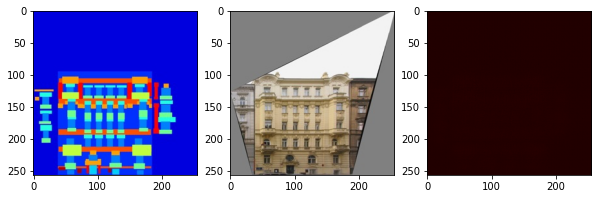

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


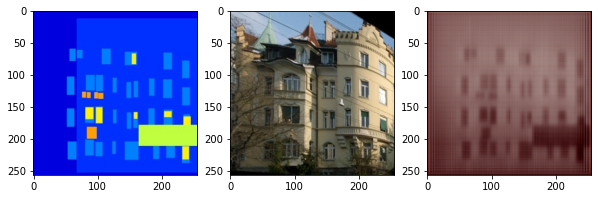

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


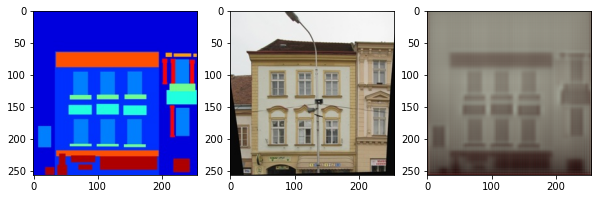

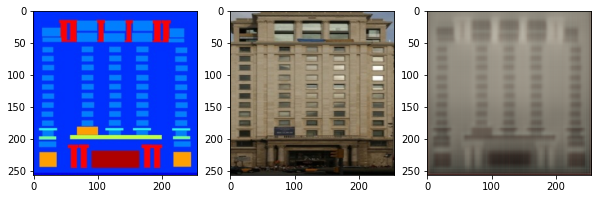

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


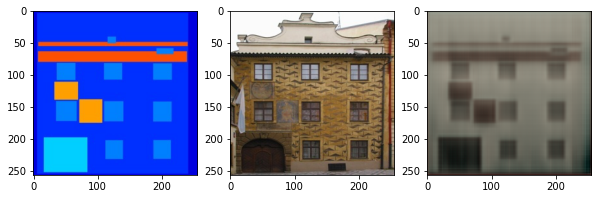

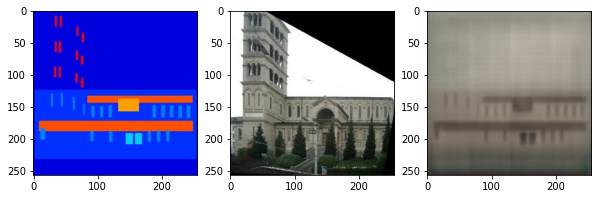

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


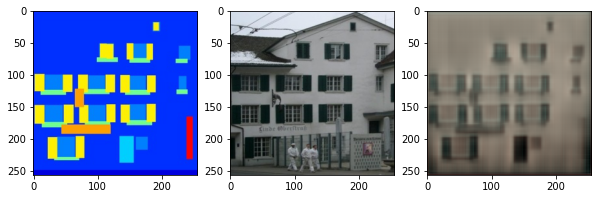

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


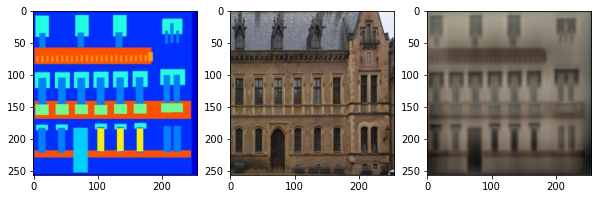

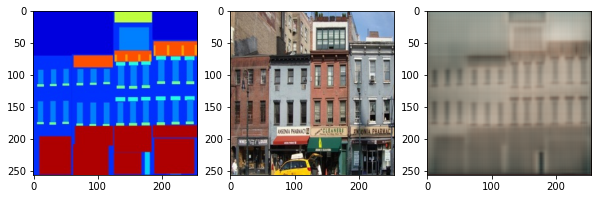

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


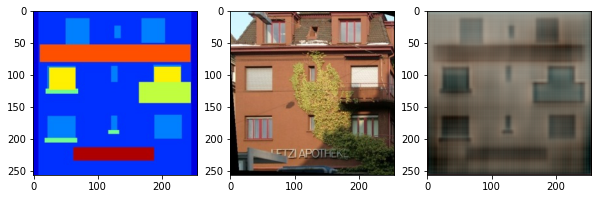

Tracker(max_epochs=0, current_epoch=9, current_step=1000, steps_per_epoch=None, train=TrackingValues(loss=18.189123172578118, steps=100, step_loss=20.436922073364258, metrics={}), val=TrackingValues(loss=None, steps=None, step_loss=None, metrics={}))

In [ ]:
model.fit(autodata, max_epochs=10, show_progress=False)

In [ ]:
# model.tracker.callback_runner.on_fit_end()